
##Data Cleaning & Preprocessing

In [ ]:
# importing libraries
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# reading raw data file
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df_har = pd.read_csv('WISDM_ar_v1.1_raw.txt', header = None, names = columns)

In [ ]:
# removing null values
df_har = df_har.dropna()
df_har.shape

(1098203, 6)

In [ ]:
# transforming the z-axis to float
df_har['z-axis'] = df_har['z-axis'].str.replace(';', '')
df_har['z-axis'] = df_har['z-axis'].apply(lambda x:float(x))

In [ ]:
# drop rows where timestamp is 0
df = df_har[df_har['timestamp'] != 0]

In [ ]:
# arrange data in ascending order of user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

##Exploratory Data Analysis

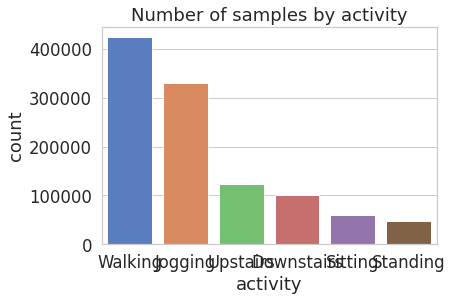

In [ ]:
sns.set_style("whitegrid")
sns.countplot(x = 'activity', data = df)
plt.title('Number of samples by activity')
plt.show()

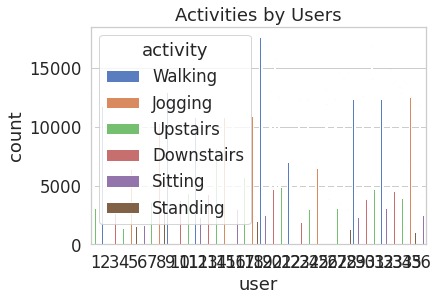

In [ ]:
sns.countplot(x = 'user',  hue = 'activity', data = df)
plt.title('Activities by Users')
plt.show()

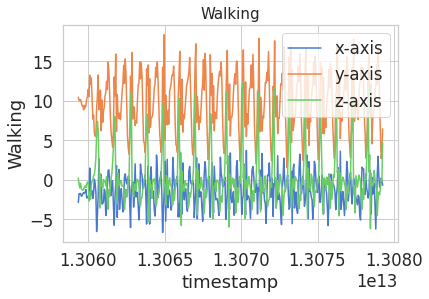

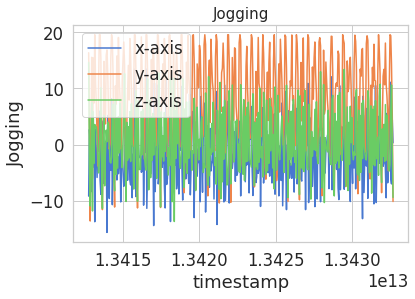

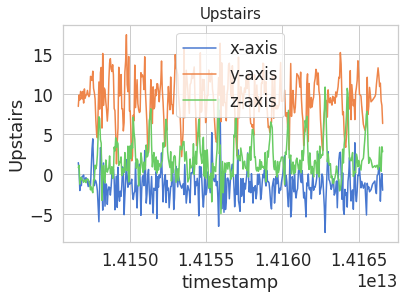

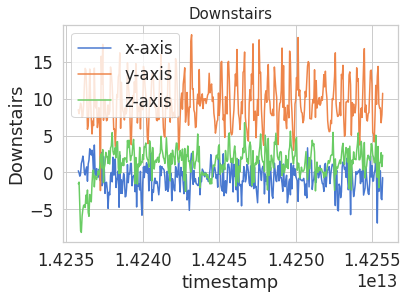

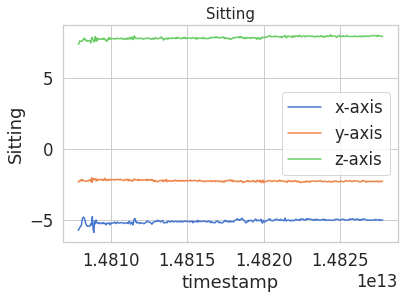

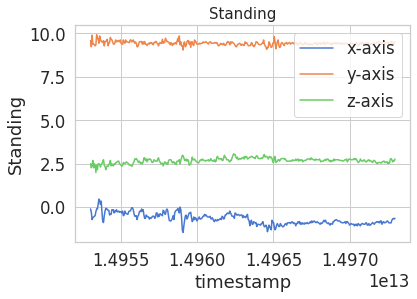

In [ ]:
activities = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
for i in activities:
    data36 = df[(df['user'] == 36) & (df['activity'] == i)][:400]
    sns.lineplot(y = 'x-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'y-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'z-axis', x = 'timestamp', data = data36)
    plt.legend(['x-axis', 'y-axis', 'z-axis'])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

##Preparing Data

In [ ]:
random_seed = 42   
n_time_steps = 50 
n_features = 3 
step = 10 
n_classes = 6 
n_epochs = 50       
batch_size = 1024   
learning_rate = 0.0025
l2_loss = 0.0015

In [ ]:
segments = []
labels = []

for i in range(0,  df.shape[0]- n_time_steps, step):  

    xs = df['x-axis'].values[i: i + 50]

    ys = df['y-axis'].values[i: i + 50]

    zs = df['z-axis'].values[i: i + 50]

    label = stats.mode(df['activity'][i: i + 50])[0][0]

    segments.append([xs, ys, zs])

    labels.append(label)

#reshape the segments which is (list of arrays) to a list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [ ]:
reshaped_segments.shape

(108531, 50, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)

## Building Model Architecture

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5)) 
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________


## Model Training & Evaluation

In [ ]:
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, batch_size = batch_size, verbose = 1)

Epoch 1/50
68/68 [==============================] - 72s 1s/step - loss: 0.9476 - accuracy: 0.6632 - val_loss: 0.5624 - val_accuracy: 0.8063
Epoch 2/50
68/68 [==============================] - 62s 907ms/step - loss: 0.5201 - accuracy: 0.8153 - val_loss: 0.4837 - val_accuracy: 0.8230
Epoch 3/50
68/68 [==============================] - 62s 908ms/step - loss: 0.4593 - accuracy: 0.8341 - val_loss: 0.4282 - val_accuracy: 0.8414
Epoch 4/50
68/68 [==============================] - 65s 955ms/step - loss: 0.4215 - accuracy: 0.8453 - val_loss: 0.3998 - val_accuracy: 0.8545
Epoch 5/50
68/68 [==============================] - 61s 887ms/step - loss: 0.3499 - accuracy: 0.8708 - val_loss: 0.3220 - val_accuracy: 0.8759
Epoch 7/50
68/68 [==============================] - 60s 890ms/step - loss: 0.3153 - accuracy: 0.8844 - val_loss: 0.2989 - val_accuracy: 0.8879
Epoch 8/50
68/68 [==============================] - 59s 865ms/step - loss: 0.2969 - accuracy: 0.8922 - val_loss: 0.3137 - val_accuracy: 0.8891
Ep

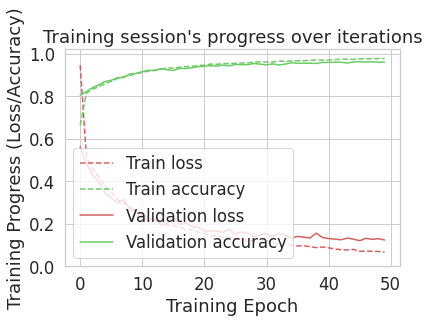

In [ ]:
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

22/22 [==============================] - 7s 300ms/step - loss: 0.1190 - accuracy: 0.9636
Test Accuracy : 0.9636062383651733
Test Loss : 0.11902851611375809


## Confusion matrix

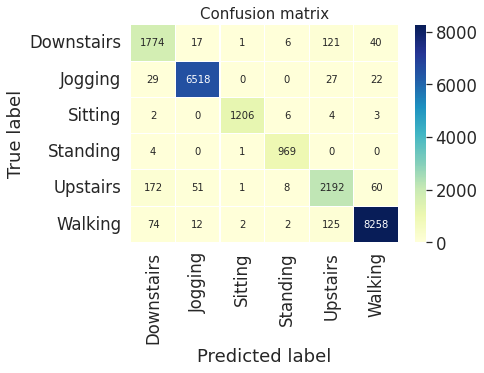

In [ ]:
predictions = model.predict(X_test)
class_labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()